# Loan Default Prediction
## Step 5: Modelling (CatBoost)
## Table of Content
1. Imports and Data Loading
2. Test CastBoost
3. Feature Reduction
4. Aggressive Feature Reduction
5. Hyperparameter Tuning
6. Final Catboost Model

## 5.1 Imports and Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#!pip install catboost

In [3]:
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [4]:
df = pd.read_csv('../data/interim/train.csv')
df.head()

,Unnamed: 0,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,5038,6071496,3,2507.210974,8599.977362,47737.07095,6,618,0
1,8929,5006576,0,3879.481181,4894.867489,70287.44380,4,631,0
2,9024,3181518,0,2517.012371,2958.774379,39506.04322,5,763,0
3,3218,3770987,2,6581.765984,9023.147830,84959.97714,8,711,0
4,8550,3481740,5,5243.031680,27422.854140,85183.17609,4,586,1


In [5]:
X = df.iloc[:,2:-1]
X.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,3,2507.210974,8599.977362,47737.07095,6,618
1,0,3879.481181,4894.867489,70287.44380,4,631
2,0,2517.012371,2958.774379,39506.04322,5,763
3,2,6581.765984,9023.147830,84959.97714,8,711
4,5,5243.031680,27422.854140,85183.17609,4,586


In [6]:
y = df['default']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: default, dtype: int64

## 5.2 Test CatBoost

We have loaded the training data into variables X and y. Here we will:
1. perform a train/test split
2. build a first CatBoost model using edfault perameters
3. examine the performance of the model

In [7]:
# Perform train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.1, random_state=23)

In [28]:
# Train a first model using default parameters
from catboost import CatBoostClassifier

model = CatBoostClassifier()
fit_model = model.fit(X_train, y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [9]:
# Use this model to predict on the test set
y_pred = fit_model.predict(X_test)
y_proba = fit_model.predict_proba(X_test)[:,1]

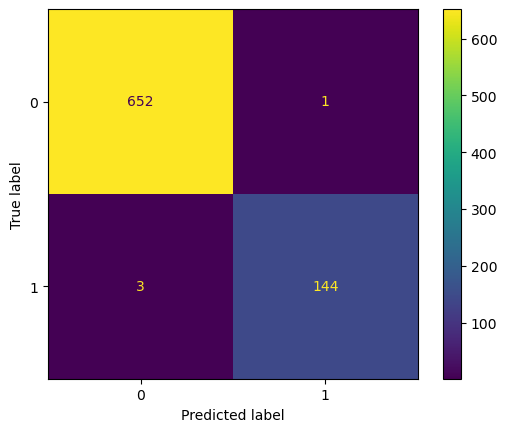

In [10]:
# visualize results with confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [11]:
# classification report
from sklearn.metrics import classification_report

target_names = ['0(no default)', '1(default)']
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

0(no default)       1.00      1.00      1.00       653
   1(default)       0.99      0.98      0.99       147

     accuracy                           0.99       800
    macro avg       0.99      0.99      0.99       800
 weighted avg       0.99      0.99      0.99       800



In [12]:
# Brier score and log loss
from sklearn.metrics import brier_score_loss, log_loss

print('Brier score loss: \t' + str(brier_score_loss(y_test, y_proba)))
print('log loss: \t\t' + str(log_loss(y_test, y_proba)))

Brier score loss: 	0.0040418590027132715
log loss: 		0.012927338497727085


ROC_AUC score:  0.9998958235667927


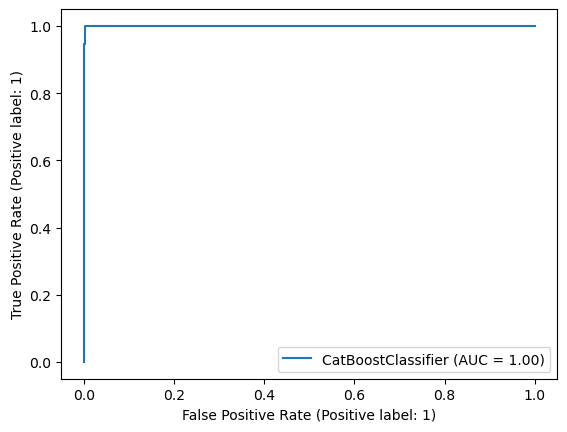

In [13]:
# AUC-ROC score and visualization
from sklearn.metrics import roc_auc_score, RocCurveDisplay

print('ROC_AUC score: ', str(roc_auc_score(y_test, y_proba)))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

## 5.3 Feature Reduction
It seems that we have done very well even with a test attempt. A reasonable next step would be reducing the number of features and see if accurate models could be built on less features available. First let's look at what features hold the most predictive power.

In [14]:
fit_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,credit_lines_outstanding,41.642504
1,years_employed,27.133336
2,total_debt_outstanding,10.848737
3,fico_score,10.598897
4,income,6.910185
5,loan_amt_outstanding,2.866341


According to the above chart, 'credit_lines_outstanding' accounts for over 42% of the predictive power. Let's remove this feature and retrain a model.

In [15]:
X1 = X.drop(columns='credit_lines_outstanding')
X1.head()

,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
0,2507.210974,8599.977362,47737.07095,6,618
1,3879.481181,4894.867489,70287.44380,4,631
2,2517.012371,2958.774379,39506.04322,5,763
3,6581.765984,9023.147830,84959.97714,8,711
4,5243.031680,27422.854140,85183.17609,4,586


In [16]:
# Perform same steps as above
X_train, X_test, y_train, y_test = \
    train_test_split(X1, y, test_size=0.1, random_state=23)

model = CatBoostClassifier()
fit_model = model.fit(X_train, y_train, verbose=False, plot=True)

y_pred = fit_model.predict(X_test)
y_proba = fit_model.predict_proba(X_test)[:,1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

               precision    recall  f1-score   support

0(no default)       0.98      1.00      0.99       653
   1(default)       0.99      0.93      0.96       147

     accuracy                           0.98       800
    macro avg       0.99      0.96      0.97       800
 weighted avg       0.99      0.98      0.98       800

Brier score loss: 	0.011271126987279716
log loss: 		0.034019660222545045
ROC_AUC score:  0.9989999062412102


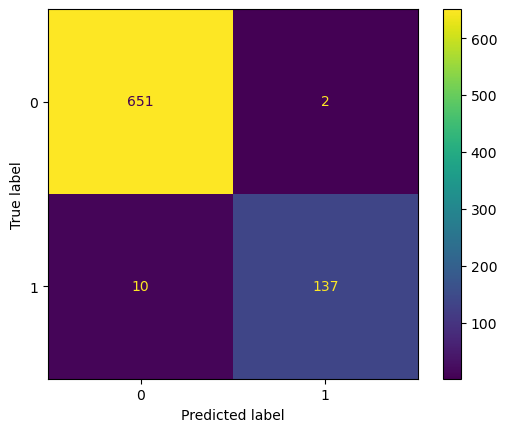

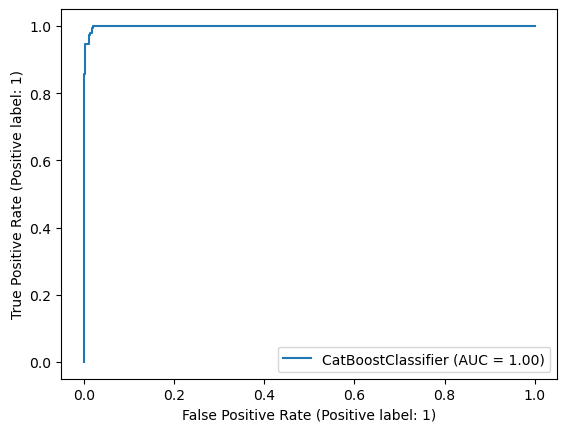

In [17]:
# Take a look at performance metrics
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

target_names = ['0(no default)', '1(default)']
print(classification_report(y_test, y_pred, target_names=target_names))

print('Brier score loss: \t' + str(brier_score_loss(y_test, y_proba)))
print('log loss: \t\t' + str(log_loss(y_test, y_proba)))

print('ROC_AUC score: ', str(roc_auc_score(y_test, y_proba)))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

## 5.4 Aggressive Feature Reduction
Let us use only 'income,' 'years_employed,' and 'fico_score' to test the effect of parameter tuning.

In [18]:
X2 = df[['income', 'years_employed', 'fico_score']]
X2.head()

,income,years_employed,fico_score
0,47737.07095,6,618
1,70287.44380,4,631
2,39506.04322,5,763
3,84959.97714,8,711
4,85183.17609,4,586


In [19]:
# Perform same steps as above
X_train, X_test, y_train, y_test = \
    train_test_split(X2, y, test_size=0.1, random_state=23)

model = CatBoostClassifier()
fit_model = model.fit(X_train, y_train, verbose=False, plot=True)

y_pred = fit_model.predict(X_test)
y_proba = fit_model.predict_proba(X_test)[:,1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

               precision    recall  f1-score   support

0(no default)       0.84      0.97      0.90       653
   1(default)       0.58      0.20      0.29       147

     accuracy                           0.83       800
    macro avg       0.71      0.58      0.60       800
 weighted avg       0.79      0.83      0.79       800

Brier score loss: 	0.13494448138370876
log loss: 		0.4323157578207221
ROC_AUC score:  0.7347563834109447


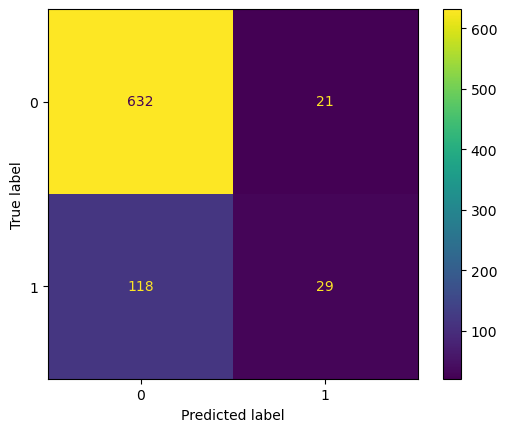

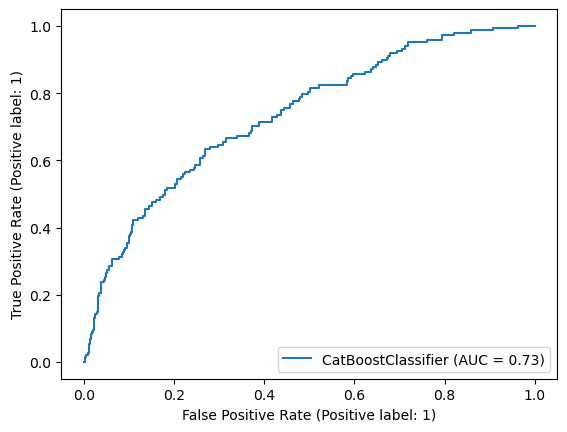

In [20]:
# Take a look at performance metrics
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

target_names = ['0(no default)', '1(default)']
print(classification_report(y_test, y_pred, target_names=target_names))

print('Brier score loss: \t' + str(brier_score_loss(y_test, y_proba)))
print('log loss: \t\t' + str(log_loss(y_test, y_proba)))

print('ROC_AUC score: ', str(roc_auc_score(y_test, y_proba)))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

## 5.5 Hyperparameter Tuning
Now we are in a place to see if the model could be optimized. Using X2 (3 features), let's start with a randomized grid search.

In [26]:
model = CatBoostClassifier(loss_function='Logloss', verbose=False)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(grid,
                                                   X=X_train,
                                                   y=y_train,
                                                   cv=3,
                                                   n_iter=10,
                                                   plot=True,
                                                   verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.3925258196
bestIteration = 108


bestTest = 0.3924510603
bestIteration = 100


bestTest = 0.3923053049
bestIteration = 154


bestTest = 0.3916892008
bestIteration = 33


bestTest = 0.3920182497
bestIteration = 190


bestTest = 0.3905961967
bestIteration = 41


bestTest = 0.3923301751
bestIteration = 41


bestTest = 0.3934945582
bestIteration = 28


bestTest = 0.3930881081
bestIteration = 113


bestTest = 0.3929081909
bestIteration = 29

Training on fold [0/3]

bestTest = 0.3958410844
bestIteration = 56

Training on fold [1/3]

bestTest = 0.3899972065
bestIteration = 40

Training on fold [2/3]

bestTest = 0.3991083149
bestIteration = 34



## 5.6 Final Catboost Model
Using the results of the last section, the best values for the test parameters are:
depth = 10 (default 6)
leaning rate = 0.1 (default 0.03)
l2 leaf ref reg = 1 (default 3.0)
Using these parameters, we will train the model and calculate metrics on the validation set.

In [22]:
# Train model on all of the training data
model = CatBoostClassifier()
fit_model = model.fit(X2, y, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
# Import validation data
df_valid = pd.read_csv('../data/interim/train.csv')
X_valid = df_valid[['income', 'years_employed', 'fico_score']]
y_valid = df_valid['default']

In [24]:
# Use the trained model to make predictions
y_pred = fit_model.predict(X_valid)
y_proba = fit_model.predict_proba(X_valid)[:,1]

               precision    recall  f1-score   support

0(no default)       0.86      0.99      0.92      6525
   1(default)       0.82      0.29      0.42      1475

     accuracy                           0.86      8000
    macro avg       0.84      0.64      0.67      8000
 weighted avg       0.85      0.86      0.83      8000

Brier score loss: 	0.10480896293054924
log loss: 		0.3409227932270669
ROC_AUC score:  0.8511689330476004


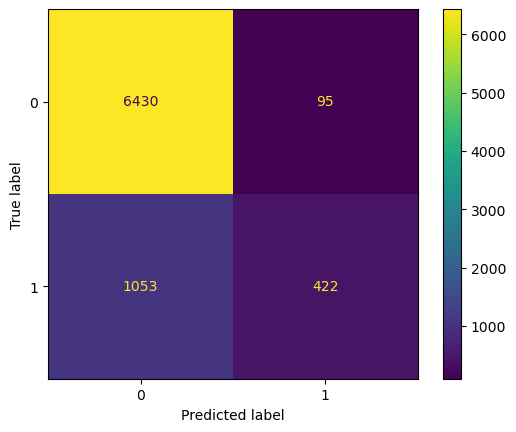

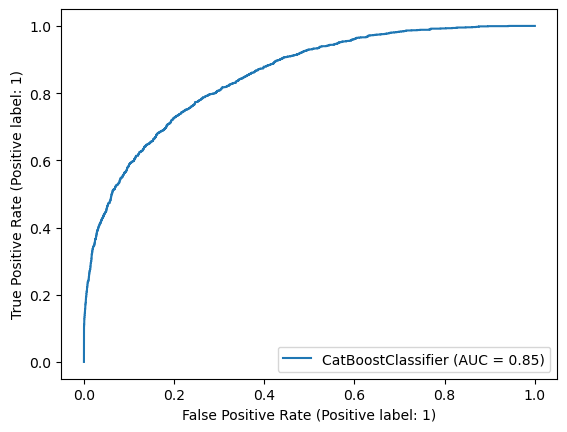

In [25]:
# Generate performance metrics from the predictions
cm = confusion_matrix(y_valid, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

target_names = ['0(no default)', '1(default)']
print(classification_report(y_valid, y_pred, target_names=target_names))

print('Brier score loss: \t' + str(brier_score_loss(y_valid, y_proba)))
print('log loss: \t\t' + str(log_loss(y_valid, y_proba)))

print('ROC_AUC score: ', str(roc_auc_score(y_valid, y_proba)))
RocCurveDisplay.from_estimator(model, X_valid, y_valid)
plt.show()